In [35]:
import datetime
import geopandas
import seaborn as sns
import matplotlib
import numpy as np
import pandas


In [89]:
BANDS = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
NUMERIC_COLS = BANDS + ['NDVI', 'NDVI_diff'] 

In [76]:
DF = geopandas.read_file('../data/merged_samples_gdf.geojson')
DF.rename(columns = {'is_within_period':'har_evnt'}, inplace = True)
DF.shape

(8928, 21)

In [77]:
NUM_SAMPLES = len(np.unique(DF.sample_idx))
DF.head()

,B11,B12,B2,B3,B4,B5,B6,B7,B8,B8A,...,finHarvDat,lat,lon,point_idx,start_date,end_date,har_evnt,sample_idx,NDVI_diff,geometry
0,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,...,2022-08-11,50.655048,25.458684,_0,2022-01-29,2022-02-18,False,_1,0.000000,POINT (25.45868 50.65505)
1,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,...,NaT,50.294633,36.289471,_1,2022-01-29,2022-02-18,False,_1,0.000000,POINT (36.28947 50.29463)
2,0.0603,0.0712,0.8832,0.8808,0.8952,0.9323,0.8933,0.8527,0.8808,0.8184,...,NaT,50.860849,32.548484,_2,2022-01-29,2022-02-18,False,_1,-0.008108,POINT (32.54848 50.86085)
3,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,0.1000,...,NaT,50.928689,31.637558,_3,2022-01-29,2022-02-18,False,_1,0.000000,POINT (31.63756 50.92869)
4,0.1662,0.1304,0.0392,0.0514,0.0719,0.0738,0.0820,0.0886,0.1092,0.0994,...,2022-07-23,48.307964,37.348245,_4,2022-01-29,2022-02-18,False,_1,-0.050371,POINT (37.34824 48.30796)


In [78]:
indices = (DF.loc[(DF.har_evnt == True)]).point_idx
points_with_change_df = DF.loc[(DF.point_idx).isin(indices)]
points_with_change_df.shape # 366 * NUM_SAMPLES rows
df = points_with_change_df

In [84]:
stretch_numeric_df = pandas.DataFrame({'value':np.array([]), 'class':np.array([]), 'har_evnt': np.array([])})
for col_name in NUMERIC_COLS:
    curr_df = pandas.DataFrame({'value': df[col_name], 'class':np.tile(np.array([col_name]), df.shape[0]), 'har_evnt':(df['har_evnt'] == True)})

    stretch_numeric_df = pandas.concat([stretch_numeric_df, curr_df])
stretch_numeric_df

/var/folders/6q/tw4w22c97c98vxdk2crxzdb00000gn/T/ipykernel_704/1766256120.py:5: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  stretch_numeric_df = pandas.concat([stretch_numeric_df, curr_df])


,value,class,har_evnt
0,0.100000,B2,0.0
4,0.039200,B2,0.0
8,0.100000,B2,0.0
10,0.033750,B2,0.0
12,0.037800,B2,0.0
...,...,...,...
8919,0.000000,NDVI_diff,0.0
8920,0.010724,NDVI_diff,0.0
8921,-0.454883,NDVI_diff,0.0
8922,0.000000,NDVI_diff,0.0


<Axes: xlabel='value', ylabel='class'>

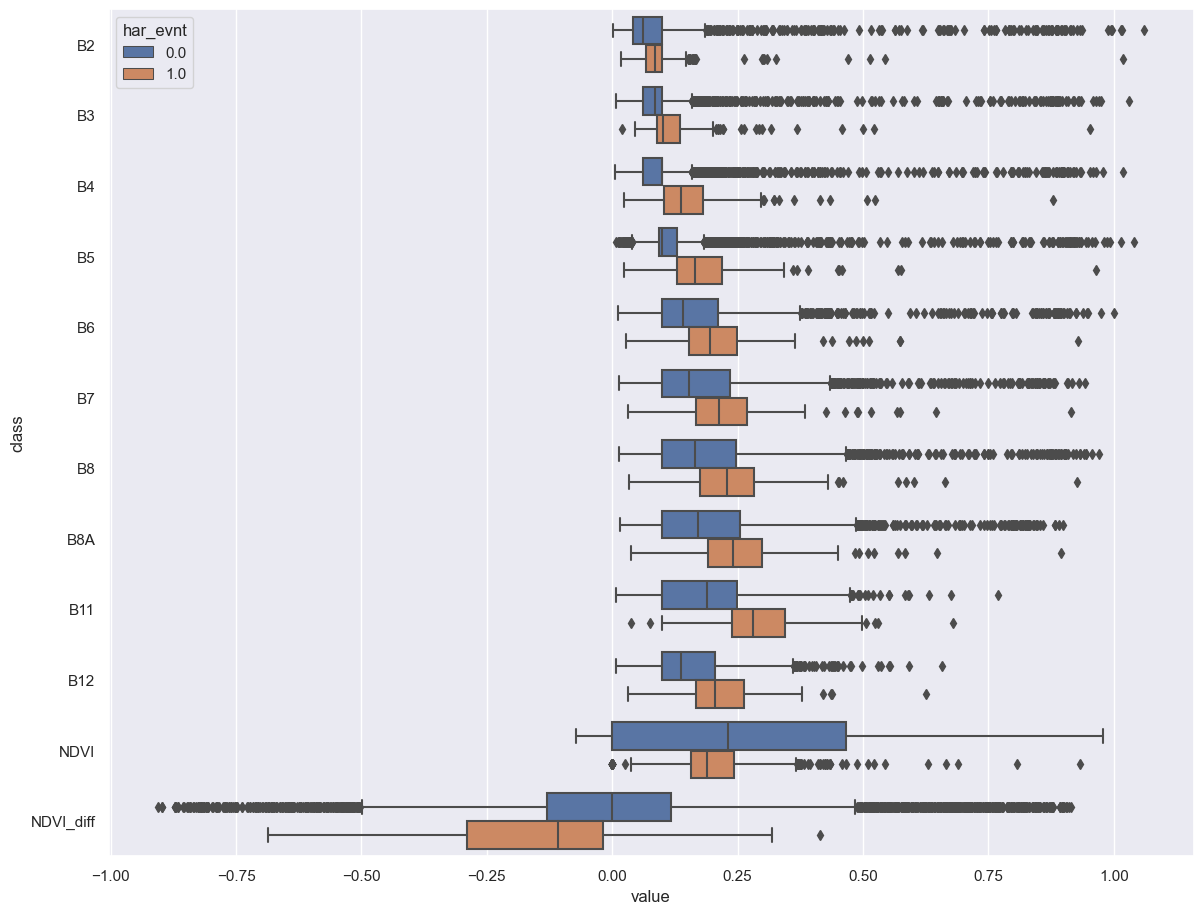

In [87]:
sns.set(rc={'figure.figsize':(14,11)})

sns.boxplot(data=stretch_numeric_df, x="value", y="class", hue="har_evnt")